In [1]:
#Import libraries
import data_preprocessing as pre
import global_vals as global_vals
import csv
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [3]:
def get_acc_roll_angle(acc_y, acc_z):
    """
    returns roll angle
    """
    return np.degrees(np.arctan(acc_y / acc_z))

def get_acc_pitch_angle(acc_x, acc_y, acc_z):
    """"
    Return Pitch angle
    """
    denominator = np.sqrt(np.power(acc_y, 2) + np.power(acc_z, 2))
    pitch_angle = np.degrees(np.arctan(((-1) * acc_x) / denominator))
    return pitch_angle

In [4]:
#Data Pre Processing
path = r'C:\\Users\\sachin.rathi\\Machine learning\\Data_Practice\\Advance Analytics course\\Telematics\\cartripsdatamining\\TripData\\RawData'
# Extract all files extension is .csv
files = glob.glob(os.path.join(path, "*.csv"))
#files = files[0:11]
data = []
for csv in files:
    header = ['time_vector(s)','rpm','speed(kmph)','engine_load','acc_x(G)','acc_y(G)','acc_z(G)','gyro_x(rad_per_s)','gyro_y(rad_per_s)','gyro_z(rad_per_s)','mag_x','mag_y','mag_z']   
    frame = pd.read_csv(csv,names=header)
    frame['date'] = os.path.basename(csv)
    data.append(frame)

In [5]:
df = pd.concat(data, ignore_index=True)
df['date'] =df['date'].apply(lambda x : x.split(".")[0].replace("_","-"))
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d-%H-%M-%S')
df = df[df['speed(kmph)'] > 0 ]  #when vehicle is moving
df.reset_index(drop=True, inplace=True)

ac = []
gy = []
for i in range(0, len(df)):
    a = max(df['acc_x(G)'][i] , df['acc_y(G)'][i] , df['acc_z(G)'][i])
    b = max(df['gyro_x(rad_per_s)'][i], df['gyro_y(rad_per_s)'][i], df['gyro_z(rad_per_s)'][i])
    ac.append(a)
    gy.append(b)

df['acc'] = ac
df['gyro'] = gy
df['accX_ms'] = df['acc_x(G)'] * 9.807
df['accY_ms'] = df['acc_y(G)'] * 9.807
df['accZ_ms'] = df['acc_z(G)'] * 9.807
df['gyroX_dps'] = df['gyro_x(rad_per_s)'] * 57.296
df['gyroY_dps'] = df['gyro_y(rad_per_s)'] * 57.296
df['gyroZ_dps'] = df['gyro_z(rad_per_s)'] * 57.296
df['acc_ms'] = df['acc']  * 9.807
df['gyro_dps'] = df['gyro'] * 57.296
df['speed_mps'] = df['speed(kmph)'] *0.278
df['acc_roll_angle'] = get_acc_roll_angle(df['accY_ms'], df['accZ_ms'])
df['acc_pitch_angle'] = get_acc_pitch_angle(df['accX_ms'], df['accY_ms'], df['accZ_ms'])
df1 = df[['date','speed_mps', 'acc_ms', 'gyro_dps', 'acc_roll_angle', 'acc_pitch_angle']]



In [6]:
df1.to_csv("C:\\Users\\sachin.rathi\\Machine learning\\Data_Practice\\Advance Analytics course\\Telematics\\telematics-master\\telematics-master\\processed_data.csv", index=False) #saving in csv

In [15]:
df1.head()

,date,speed_mps,acc_ms,gyro_dps,acc_roll_angle,acc_pitch_angle
0,2017-04-03 09:13:32,0.834,0.215754,0.000000,-1.260304,-0.630076
1,2017-04-03 09:13:32,0.834,0.196140,0.057296,-1.151519,-1.151286
2,2017-04-03 09:13:32,0.834,0.186333,0.057296,-1.098372,-0.000000
3,2017-04-03 09:13:32,0.556,0.382473,0.057296,-1.858845,-2.263892
4,2017-04-03 09:13:32,0.556,0.402087,0.057296,-2.381110,-1.799242


In [17]:
class Driver:
    
    def __init__(self):
        #preprocess = pre.data_preprocess()
        self.dataset = df1
        self.file_init = False
        self.file_name = 'feature_outputs/'
        
    def get_dataset(self):
        return self.dataset
    
    def generate_features_csv(self,feature_vector,row_count):
        if(self.file_init == False):
            self.file_name += "driver_features.csv"
            self.file_init = True
            header = ['index','max_speed','max_rotation','max_acc','avg_acc','avg_rotation','avg_speed','min_acc','min_speed','min_rotation','acc_roll_angle', 'acc_pitch_angle']
            with open(self.file_name, 'w') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(header)
            writeFile.close()
        else:
            feature_vector = list(feature_vector.values())
            feature_vector = [row_count]+feature_vector
            with open(self.file_name, 'a') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(feature_vector)
            writeFile.close()
    
    def write_features(self,feature_vector,row_count):
        if(self.file_init == False):
            self.file_name += "driver_features.csv"
            self.file_init = True
            header = ['index','max_speed','max_rotation','max_acc','avg_acc','avg_rotation','avg_speed','min_acc','min_speed','min_rotation','acc_roll_angle', 'acc_pitch_angle','score']
            with open(self.file_name, 'w') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(header)
            writeFile.close()
        else:
            score = 10.0
            if (feature_vector['max_speed'] > 10.5):
                score = score - 1.3
            elif (feature_vector['max_speed'] >12.5):
                score = score - 2.9
            elif (feature_vector['max_speed'] > 15.0): 
                score = score - 5.7
            if (feature_vector['avg_speed'] >10.5):
                score = score - 1.5
            #no need for other speed conditions since max conditions covers them
            if (feature_vector['max_rotation'] >0.1):
                score = score - 0.5
            elif (feature_vector['max_rotation'] >0.8):
                score = score - 0.8
            if (feature_vector['avg_rotation'] >0.1):
                score = score - 0.6
            if (feature_vector['max_acc'] >1.5 and feature_vector['max_acc'] <2.0):
                score = score - 1.8
            elif (feature_vector['max_acc'] >1.0 and feature_vector['max_acc'] <2.0):
                score = score - 1.0
            if (feature_vector['avg_acc'] >1.0):
                score = score - 0.4
            feature_vector = list(feature_vector.values())
            feature_vector = [row_count]+feature_vector+[score]
            with open(self.file_name, 'a') as writeFile:
                writer = csv.writer(writeFile)
                writer.writerow(feature_vector)
            writeFile.close()
            

    
    def generate_feature_vectors(self):
        self.data_rows = self.dataset.iloc[:,:-1].values.tolist()
        self.feature_vector = {}
        speed = self.dataset['speed_mps'].values
        acc = self.dataset['acc_ms'].values
        gyro = self.dataset['gyro_dps'].values
        acc_roll_angle = self.dataset['acc_roll_angle'].values
        acc_pitch_angle = self.dataset['acc_pitch_angle'].values
        print(len(self.data_rows))
        for row_count in range(len(self.data_rows)):
            feature_element = {}
            max_speed = 0
            min_speed = 999
            avg_speed = 0
            max_acc = 0
            min_acc =999
            avg_acc = 0
            max_rotation = 0
            min_rotation = 999
            avg_rotation = 0
            count=0
            if (row_count+global_vals.sample_size>len(self.data_rows)):
                global_vals.sample_size = global_vals.sample_size - row_count - 1
            while count in range(global_vals.sample_size):
                max_speed = abs(speed[row_count+count]) if abs(speed[row_count+count])>max_speed else max_speed
                max_rotation = abs(gyro[row_count+count]) if abs(gyro[row_count+count])>max_rotation else max_rotation
                max_acc = abs(acc[row_count+count]) if abs(acc[row_count+count])>max_acc else max_acc
                acc_roll = acc_roll_angle[row_count+count]
                acc_pitch = acc_pitch_angle[row_count+count]

                avg_speed+=abs(speed[row_count+count])
                avg_acc+=abs(acc[row_count+count])
                avg_rotation+=abs(gyro[row_count+count])
                
                min_speed = abs(speed[row_count+count]) if abs(speed[row_count+count])<min_speed else min_speed
                min_rotation = abs(gyro[row_count+count]) if abs(gyro[row_count+count])<min_rotation else min_rotation
                min_acc = abs(acc[row_count+count]) if abs(acc[row_count+count])<min_acc else min_acc
                count+=1
            
            if(count>0):
                avg_acc/=global_vals.sample_size
                avg_speed/=global_vals.sample_size
                avg_rotation/=global_vals.sample_size
                
                feature_element['max_speed'] = max_speed
                feature_element['max_rotation'] = max_rotation
                feature_element['max_acc'] = max_acc
                feature_element['avg_acc'] = avg_acc
                feature_element['avg_rotation'] = avg_rotation
                feature_element['avg_speed'] = avg_speed
                feature_element['min_acc'] = min_acc
                feature_element['min_speed'] = min_speed
                feature_element['min_rotation'] = min_rotation
                feature_element['acc_roll_angle'] = acc_roll
                feature_element['acc_pitch_angle'] = acc_pitch
                
                
                if global_vals.train_mode == True:
                    self.write_features(feature_element,row_count)
                else:
                    self.generate_features_csv(feature_element,row_count)
                
                
                self.feature_vector[row_count] = feature_element

        return self.feature_vector

In [7]:
Driver_obj = Driver()
feature_dict = Driver_obj.generate_feature_vectors()

91610


In [20]:
Driver_obj = Driver()
feature_dict = Driver_obj.generate_feature_vectors()

91610


In [14]:
#Driver_obj = Driver()

In [56]:
df2 = pd.read_csv('feature_outputs/driver_features.csv')
df2 = df2.drop(['index'], axis=1)

In [3]:
df2.head()

,max_speed,max_rotation,max_acc,avg_acc,avg_rotation,avg_speed,min_acc,min_speed,min_rotation,acc_roll_angle,acc_pitch_angle,score
0,1.112,3.666944,0.774753,0.341284,0.538582,0.8340,0.137298,0.556,0.057296,-3.791742,-2.157257,8.9
1,1.112,6.130672,0.774753,0.331477,1.145920,0.8618,0.098070,0.556,0.057296,5.184349,0.556679,8.9
2,1.112,6.130672,0.774753,0.352071,1.736069,0.8896,0.098070,0.556,0.057296,9.335799,-2.366690,8.9
3,1.390,10.542464,0.774753,0.355013,2.784586,0.9730,0.098070,0.556,0.057296,6.290228,-2.373949,8.9
4,1.390,10.542464,0.774753,0.371685,2.853341,1.0286,0.098070,0.556,0.057296,14.685577,-3.300141,8.9


In [4]:
#Modeling
X = df2.iloc[:, :11].values
y = df2.iloc[:, 11].values

for count in range(0,len(y)):
    if y[count] <7.5:
        y[count]=0
    else:
        y[count]=1

In [5]:
df2['score'].value_counts()

0.0    52357
1.0    39243
Name: score, dtype: int64

#### Logistic Regression 

In [42]:
#Modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
lr = LogisticRegression()
lr.fit(X_train, y_train)

print(lr.coef_)
print(lr.intercept_)

y_pred = lr.predict(X_test)



print(confusion_matrix(y_test, y_pred))

#Accuracy of the model
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(lr.score(X_test, y_test)))

print(classification_report(y_test, y_pred))

[[-0.2104354   0.01601282  0.00295156 -0.26991448 -0.03050183 -0.09665994
  -0.69853224 -0.16171267 -0.04630147  0.00863051 -0.00290165]]
[4.0277035]
[[8898 1458]
 [1535 6429]]
Accuracy of logistic regression classifier on test set: 0.84
              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86     10356
         1.0       0.82      0.81      0.81      7964

    accuracy                           0.84     18320
   macro avg       0.83      0.83      0.83     18320
weighted avg       0.84      0.84      0.84     18320



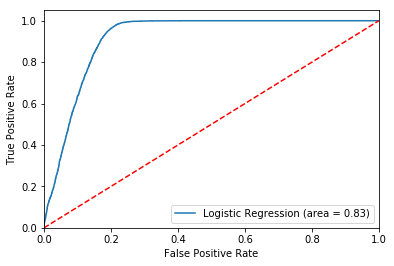

In [43]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test,lr.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Extreme Gradient Boost

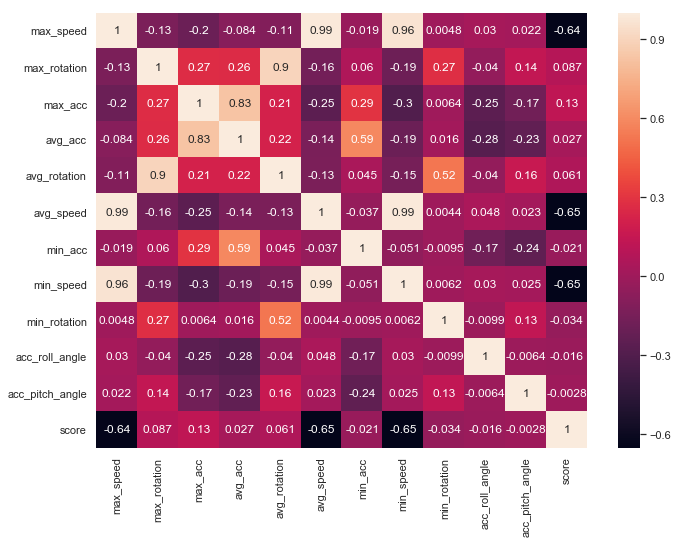

In [45]:
import seaborn as sns
sns.set(rc={'figure.figsize':(11,8)})
Var_Corr = df2.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True)



###### Find corelation strength between variables

In [46]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df2.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df2.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df2)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [47]:
print(get_top_abs_correlations(df2, 20))

avg_speed     min_speed          0.989712
max_speed     avg_speed          0.989512
              min_speed          0.962921
max_rotation  avg_rotation       0.900003
max_acc       avg_acc            0.826332
avg_speed     score              0.649998
min_speed     score              0.645653
max_speed     score              0.641453
avg_acc       min_acc            0.590391
avg_rotation  min_rotation       0.523658
max_acc       min_speed          0.298715
              min_acc            0.292860
avg_acc       acc_roll_angle     0.278580
max_rotation  min_rotation       0.274247
              max_acc            0.265717
              avg_acc            0.263218
max_acc       acc_roll_angle     0.253592
              avg_speed          0.250585
min_acc       acc_pitch_angle    0.243411
avg_acc       acc_pitch_angle    0.232228
dtype: float64


In [169]:
A =df2.iloc[:,0:11]

B= df2[['score']]

B['score'] = np.where(B['score'] <= 7.5, 0, 1)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(A, B,
                                                    stratify=y, 
                                                    test_size=0.25)

In [96]:
df2.shape , X_train.shape , y_train.shape,X_test.shape,y_test.shape

((91600, 12), (68700, 11), (68700, 1), (22900, 11), (22900, 1))

In [60]:
import xgboost as xgb
model= xgb.XGBClassifier(random_state=1,learning_rate=0.01)

model = model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test,y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13137     0]
 [    0  9763]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13137
           1       1.00      1.00      1.00      9763

    accuracy                           1.00     22900
   macro avg       1.00      1.00      1.00     22900
weighted avg       1.00      1.00      1.00     22900



##### Hyper parameter tuning for XGB

In [170]:
from sklearn.model_selection import GridSearchCV
params = {
     'learning_rate': [0.01],
     'n_estimators': [900,1000,1100],
     'max_depth':[7,8,9],
     'reg_alpha':[0.3,0.4,0.5]
    }
 
# Initializing the XGBoost Regressor
xgb_model = xgb.XGBClassifier()
 
# Gridsearch initializaation
gsearch = GridSearchCV(xgb_model, params,
                    verbose=True,
                    cv=5,
                    n_jobs=2)
 
gsearch.fit(X_train, y_train)
 
#Printing the best chosen params
print("Best Parameters :",gsearch.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 27.0min
[Parallel(n_jobs=2)]: Done 135 out of 135 | elapsed: 82.1min finished


Best Parameters : {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 900, 'reg_alpha': 0.3}


In [172]:
params = {'objective':'binary:logistic', 'booster':'gbtree'}
params.update(gsearch.best_params_)

In [174]:
xgb_model_tuned = xgb.XGBClassifier(**params,random_state=100)
xgb_model_tuned.fit(X_train, y_train)

y_pred = xgb_model_tuned.predict(X_test)

accuracy_score(y_test,y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13143     0]
 [    0  9757]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13143
           1       1.00      1.00      1.00      9757

    accuracy                           1.00     22900
   macro avg       1.00      1.00      1.00     22900
weighted avg       1.00      1.00      1.00     22900



In [173]:
#Check Accuracy on train and test dataset

model = XGBClassifier()
model.fit(X_train,y_train)

# predict the target on the train dataset
predict_train = model.predict(X_train)
print('\nTarget on train data',predict_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('\naccuracy_score on train dataset : ', accuracy_train)

# predict the target on the test dataset
predict_test = model.predict(X_test)
print('\nTarget on test data',predict_test) 
 
# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_test)


Target on train data [0 0 0 ... 0 0 0]

accuracy_score on train dataset :  1.0

Target on test data [0 1 1 ... 1 1 1]

accuracy_score on test dataset :  1.0


In [174]:
model.predict(X_test.iloc[[1]])

array([1])

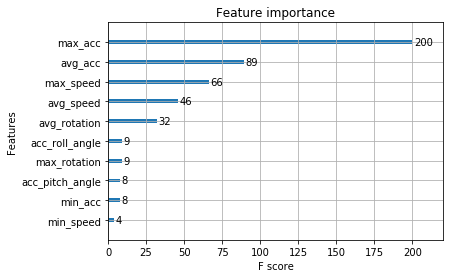

In [196]:
xgb.plot_importance(model)

In [213]:
#model.feature_importances_
colm =model.get_booster().get_score(importance_type='weight')
{k: v for k, v in sorted(colm.items(), key=lambda item: item[1])}

{'min_speed': 4,
 'min_acc': 8,
 'acc_pitch_angle': 8,
 'max_rotation': 9,
 'acc_roll_angle': 9,
 'avg_rotation': 32,
 'avg_speed': 46,
 'max_speed': 66,
 'avg_acc': 89,
 'max_acc': 200}

In [198]:
for col,score in zip(X_train.columns,model.feature_importances_):
    print(col,score)

max_speed 0.77432954
max_rotation 6.182582e-05
max_acc 0.1491896
avg_acc 0.031780116
avg_rotation 0.0022079302
avg_speed 0.04221011
min_acc 0.000106286185
min_speed 5.384617e-05
min_rotation 0.0
acc_roll_angle 1.1511216e-05
acc_pitch_angle 4.9179904e-05


##### Run model with important variables

In [61]:
X_test = X_test[['max_acc','avg_acc','max_speed','avg_speed','avg_rotation','acc_roll_angle']]
X_train = X_train[['max_acc','avg_acc','max_speed','avg_speed','avg_rotation','acc_roll_angle']]

In [62]:
import xgboost as xgb
model= xgb.XGBClassifier(random_state=1,learning_rate=0.01)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy_score(y_test,y_pred)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[13137     0]
 [    0  9763]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13137
           1       1.00      1.00      1.00      9763

    accuracy                           1.00     22900
   macro avg       1.00      1.00      1.00     22900
weighted avg       1.00      1.00      1.00     22900



In [297]:
from eli5 import show_prediction
eli5.show_prediction(lr,X_test[0],show_feature_values=True)

# LightGBM :LightGBM with all columns

In [63]:
import lightgbm as lgb

In [129]:
A =df2.iloc[:,0:11]

B= df2[['score']]

B['score'] = np.where(B['score'] <= 7.5, 0, 1)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(A, B,
                                                    stratify=y, 
                                                    test_size=0.25, random_state=10)

l = lgb.LGBMClassifier(objective='binary')

l.fit(X_train, y_train)

y_pred_lightgbm = l.predict(X_test)

print(confusion_matrix(y_test, y_pred_lightgbm))
print(classification_report(y_test, y_pred_lightgbm))

[[13116    13]
 [    4  9767]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13129
           1       1.00      1.00      1.00      9771

    accuracy                           1.00     22900
   macro avg       1.00      1.00      1.00     22900
weighted avg       1.00      1.00      1.00     22900



In [130]:
print(l.score(X_test,y_test))
print(l.score(X_train,y_train))

0.9992576419213974
1.0


In [131]:
accuracy_score(y_test,y_pred_lightgbm)

0.9992576419213974

In [70]:
from sklearn.metrics import f1_score

In [71]:
f1_score(y_test, y_pred_lightgbm)

0.998055868208329

#### LBM with Selected columns

In [135]:
# Remove Corelated variables ( Pearson Corelation)

In [139]:
A =df2.iloc[:,0:11]

B= df2[['score']]

B['score'] = np.where(B['score'] <= 7.5, 0, 1)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(A, B,
                                                    stratify=y, 
                                                    test_size=0.25,random_state=10)

X_test_selected = X_test[['max_acc','avg_acc','avg_speed','avg_rotation','acc_roll_angle','acc_pitch_angle']]
X_train_selected= X_train[['max_acc','avg_acc','avg_speed','avg_rotation','acc_roll_angle','acc_pitch_angle']]

lgb_selected = lgb.LGBMClassifier(objective='binary')

lgb_selected.fit(X_train_selected, y_train)

y_pred_lightgbm_selected = lgb_selected.predict(X_test_selected)

print(confusion_matrix(y_test, y_pred_lightgbm_selected))
print(classification_report(y_test, y_pred_lightgbm_Selected))

[[12826   303]
 [  140  9631]]
              precision    recall  f1-score   support

           0       0.58      0.58      0.58     13129
           1       0.43      0.43      0.43      9771

    accuracy                           0.52     22900
   macro avg       0.51      0.51      0.51     22900
weighted avg       0.52      0.52      0.52     22900



In [167]:
print(f'Accuracy for lightGBM with selected variables is : {accuracy_score(y_test, y_pred_lightgbm_selected)}')
print('\n')
print(f'Are under the curve : {roc_auc_score(y_test, y_pred_lightgbm_selected)}')
print('\n')
print(f'Recall is : {recall_score(y_test, y_pred_lightgbm_selected)}')


Accuracy for lightGBM with selected variables is : 0.9806550218340612


Are under the curve : 0.9812966027054197


Recall is : 0.9856718861938389


#### Calculate VIF

In [171]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(exog_df):
    '''
    Parameters
    ----------
    exog_df : dataframe, (nobs, k_vars)
        design matrix with all explanatory variables, as for example used in
        regression.

    Returns
    -------
    vif : Series
        variance inflation factors
    '''
    exog_df = add_constant(exog_df)
    vifs = pd.Series(
        [1 / (1. - OLS(exog_df[col].values, 
                       exog_df.loc[:, exog_df.columns != col].values).fit().rsquared) 
         for col in exog_df],
        index=exog_df.columns,
        name='VIF'
    )
    return vifs

variance_inflation_factors(df2)

const               79.678052
max_speed          148.305208
max_rotation         7.514442
max_acc              4.141168
avg_acc              6.091741
avg_rotation         9.347992
avg_speed          543.640653
min_acc              1.966709
min_speed          163.497925
min_rotation         1.934292
acc_roll_angle       1.312568
acc_pitch_angle      1.147618
score                2.082462
Name: VIF, dtype: float64

##### LightGBM without Speed column ( But results does not seems satisfactory"

In [168]:
A =df2.iloc[:,0:11]

B= df2[['score']]

B['score'] = np.where(B['score'] <= 7.5, 0, 1)



from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(A, B,
                                                    stratify=y, 
                                                    test_size=0.25,random_state=10)

import lightgbm as lgb
X_test_selected2 = X_test[['max_acc','avg_acc','avg_rotation','acc_roll_angle','acc_pitch_angle']]
X_train_selected2= X_train[['max_acc','avg_acc','avg_rotation','acc_roll_angle','acc_pitch_angle']]

lgb_model_selected2 = lgb.LGBMClassifier(objective='binary')

lgb_model_selected2.fit(X_train_selected2, y_train)

y_pred_lightgbm_selected_WO_Speed = lgb_model_selected.predict(X_test_selected2)

print(confusion_matrix(y_test, y_pred_lightgbm_selected_WO_Speed))
print(classification_report(y_test, y_pred_lightgbm_selected_WO_Speed))
print(accuracy_score(y_test, y_pred_lightgbm_selected_WO_Speed))


[[10882  2242]
 [ 3296  6480]]
              precision    recall  f1-score   support

           0       0.77      0.83      0.80     13124
           1       0.74      0.66      0.70      9776

    accuracy                           0.76     22900
   macro avg       0.76      0.75      0.75     22900
weighted avg       0.76      0.76      0.76     22900

0.7581659388646288


In [110]:
#After removing Speed column, there is drastically decrease in accuracy score.